# Hands-On #11 : Balancing the Cart Pole w/ DDPG!
---

### Goal:
- Implement DDPG on the CartPole Environment
    * It is an overkill, but we will get a good understanding and also can compare against other algorithms
    
### Steps:
1. Program DDPG Algorithm
2. Run and Optimize
3. Plot Values, like we did in other exercises

### Notebook Organization
#### The program has 3 parts :
- Part 1 Defines the classes, initiates the environment and so forth. It sets up all the scaffolding needed
- Part 2 Explore and Learn - it performs the DDPG Reinforcement Learning. It also saves the best model
- Part 3 Run saved model

## Part 1 - Definitions & Setup

### 1.1. Install the required packages

The required setup is detailed in the README.md

I am running this on a MacBookPro 14,3 

### 1.2. Define imports

python 3, numpy, matplotlib, torch

In [1]:
# General imports
import numpy as np
import random
from collections import namedtuple, deque
import copy

import time
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
%matplotlib inline

# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# Constants Definitions
BUFFER_SIZE = 4096 # 2048 # 512 # int(1e5) # int(1e6) # int(1e5)  # replay buffer size  ?
BATCH_SIZE = 64 # 32 # 128 # 64 # 256        # minibatch size for training
GAMMA = 0.99            # discount factor
TAU = 0.05 # 1e-3              # for soft update of target parameters
LR_ACTOR = 0.01 # 5e-4 # 1e-4 # 0.001 # 1e-4         # learning rate of the actor 
LR_CRITIC = 0.001 # 6e-4 # 3e-4  # 3e-3 # 0.001 # 3e-4        # learning rate of the critic 0.001
WEIGHT_DECAY = 0.0001   # L2 weight decay
# Number of neurons in the layers of the Actor & Critic Networks
FC_UNITS_ACTOR = [16,8] # [4,4] # [32,16] #[400,300] #[8,8] #[128,128] # [64,128] # [32,16] # [400,300] # [128,128]
FC_UNITS_CRITIC = [16,8] #[4,4] # [32,16] #[400,300] #[8,8] #[128,128] # [64,128] # [32,16] # [400,300] # [128,128]
# Store models flag. Store during calibration runs and do not store during hyperparameter search
# Used in Part 3 to run a stored model
STORE_MODELS = False # True - Turn it on when you are ready to do the calibration training 

In [3]:
'''import gym, PIL
env = gym.make('CartPole-v0')
array = env.reset()
PIL.Image.fromarray(env.render(mode='rgb_array'))
'''

"import gym, PIL\nenv = gym.make('CartPole-v0')\narray = env.reset()\nPIL.Image.fromarray(env.render(mode='rgb_array'))\n"

### 3.0 Create instance & Explore

In [4]:
import gym
env = gym.make('CartPole-v0')
env.seed(42)
# array = env.reset()
env.reset()
# env.render()
#PIL.Image.fromarray(env.render(mode='rgb_array'))

/miniconda3/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


array([-0.01258566, -0.00156614,  0.04207708, -0.00180545])

### 3.1 Examine the State and Action Spaces

* The state space is continuous, with an observation space of 4 
    * {x,$\dot{x}$,$\theta$, theta_dot}
        * Cart Position,  Cart Velocity, Pole Angle, Pole Velocity at tip
        * The angle, probably, is in radians

The action space, on the contrary is simple viz. 0 = Left, 1 = Right

In [5]:
print(env.observation_space)
print(env.action_space)
act_space = [i for i in range(0,env.action_space.n)]
print(act_space)
# env.unwrapped.get_action_meanings() # AttributeError: 'FrozenLakeEnv' object has no attribute 'get_action_meanings'
print('[ 0 = Left, 1 = Right ]')

Box(4,)
Discrete(2)
[0, 1]
[ 0 = Left, 1 = Right ]


In [6]:
print(dir(env))
print(dir(env.unwrapped))
# To see what functions and variables are availabe
print('States = ',env.unwrapped.observation_space)
print('Actions = ',env.unwrapped.action_space)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_elapsed_seconds', '_elapsed_steps', '_episode_started_at', '_max_episode_seconds', '_max_episode_steps', '_past_limit', 'action_space', 'class_name', 'close', 'compute_reward', 'env', 'metadata', 'observation_space', 'render', 'reset', 'reward_range', 'seed', 'spec', 'step', 'unwrapped']
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'action_space', 'cl

In [7]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

### 4. Test the environment with Random Action

In [8]:
for i_episode in range(3):
    state = env.reset()
    tot_reward = 0
    steps = 0
    while True:
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        print('[',state,']','->', action,' : [',next_state,']', 'R=',reward)
        # env.render()
        tot_reward += reward
        steps += 1
        if done:
            print('Episode {:d} finished after {:d} steps with a Total Reward = {:.0f}'.
                  format(i_episode+1,steps, tot_reward))
            break
        else:
            state = next_state
# Pole angle +/-12 degrees, Cart Pos +/- 2.4 or 200 steps
# Cart Pos, Velocity, Pole Angle, Velocity
# 12 degrees = .2094 radians

[ [ 0.00560942  0.01842265 -0.03590751 -0.0120678 ] ] -> 0  : [ [ 0.00597787 -0.17616644 -0.03614886  0.26907314] ] R= 1.0
[ [ 0.00597787 -0.17616644 -0.03614886  0.26907314] ] -> 1  : [ [ 0.00245454  0.01945224 -0.0307674  -0.03478864] ] R= 1.0
[ [ 0.00245454  0.01945224 -0.0307674  -0.03478864] ] -> 1  : [ [ 0.00284359  0.21500159 -0.03146317 -0.33701802] ] R= 1.0
[ [ 0.00284359  0.21500159 -0.03146317 -0.33701802] ] -> 0  : [ [ 0.00714362  0.02034118 -0.03820353 -0.05442056] ] R= 1.0
[ [ 0.00714362  0.02034118 -0.03820353 -0.05442056] ] -> 1  : [ [ 0.00755044  0.2159895  -0.03929194 -0.35890801] ] R= 1.0
[ [ 0.00755044  0.2159895  -0.03929194 -0.35890801] ] -> 1  : [ [ 0.01187023  0.41164734 -0.0464701  -0.66371712] ] R= 1.0
[ [ 0.01187023  0.41164734 -0.0464701  -0.66371712] ] -> 1  : [ [ 0.02010318  0.60738391 -0.05974445 -0.97066231] ] R= 1.0
[ [ 0.02010318  0.60738391 -0.05974445 -0.97066231] ] -> 1  : [ [ 0.03225086  0.80325467 -0.07915769 -1.28149866] ] R= 1.0
[ [ 0.03225086  

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device = {}'.format(device))

Device = cpu


## The Algorithm

### Learning Algorithm

We are using the DDPG. I liked the simple systems diagram that Prof. Sergey Levine from UC Berkeley uses for his CS294 Deep Reinforcement Learning class[http://rail.eecs.berkeley.edu/deeprlcourse/]
<img src="RL_Systems_Flow.png">

The major components of the algorithm are:
1. `Actor` implemented as a Deep Neural Network whih consists of fully connected layers.
2. `Critic` implemented as a Deep Neural Network which consists of fully connected networks
3. `Experience replay buffer` - in order to train the network we take actions and then store the results in the replay buffer. The replay buffer is a circular buffer and it has methods to sample a random batch
3. `The Agent` brings all of the above together. It interacts with the environment by taking actions based on a policy, collects rewards and the observation feedback, then stores the experience in the replay buffer and also initiates a learning step on the actor and critic networks
     * The agent has 3 main components viz:
         1. The DDPG Orchestrator which interacts with the environment by taking actions and then unpacking the returned package to rewards, state space et al.
         2. It also has to do housekeeping like tracking scores, store high performant models and check when the problem is solved
         3. The 3rd component is the most interesting one - it gives the agent the capability to hunt for the right policy !!

### Pseudo Code
<img src="DDPG_Alg.png">

In [10]:
class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size=state_size, action_size=action_size, seed=42, fc_units=FC_UNITS_ACTOR):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state, defaults to the global state size from the env
            action_size (int): Dimension of each action, defaults to the global action size from the env
            seed (int): Random seed
            fc_units (list(int)): Number of nodes in the hidden layers as a list
            ** Hard coded as a 3 layer network 
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.model = nn.Sequential(
            #nn.BatchNorm1d(state_size),
            nn.Linear(state_size,fc_units[0]),
            nn.ReLU(),
            #nn.BatchNorm1d(fc_units[0]),
            nn.Linear(fc_units[0],fc_units[1]),
            nn.ReLU(),
            #nn.BatchNorm1d(fc_units[1]),
            nn.Linear(fc_units[1],action_size),
            # nn.Tanh() # for continuous -1 to +1
            nn.Softmax(dim=-1)
            # nn.Sigmoid() # for 0-1
        )
        self.model.apply(self.init_weights)

    def init_weights(self,m):
        if (type(m) == nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            #nn.init.xavier_normal_(m.weight)
            # nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(1.0)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        return self.model(state)

In [11]:
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size = state_size, action_size = action_size, seed=42, fc_units=FC_UNITS_CRITIC):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state, defaults to the global state size from the env
            action_size (int): Dimension of each action, defaults to the global action size from the env
            seed (int): Random seed
            fc_units (list(int)): Number of nodes in the hidden layers as a list
            ** Hard coded as a 3 layer network 
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.hc_1 = nn.Sequential(
            nn.Linear(state_size,fc_units[0]),
            nn.ReLU(), # leaky relu ?
            # nn.BatchNorm1d(fc_units[0])
        )
        self.hc_2 = nn.Sequential(
            nn.Linear(fc_units[0]+action_size,fc_units[1]),
            nn.ReLU(), # leaky relu ?
            nn.Linear(fc_units[1],1)
        )
        # Initialize the layers
        self.hc_1.apply(self.init_weights)
        self.hc_2.apply(self.init_weights)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = self.hc_1(state)
        x = torch.cat((xs, action), dim=1)
        x = self.hc_2(x)
        return (x)
    
    def init_weights(self,layer):
        if (type(layer) == nn.Linear):
            nn.init.xavier_uniform_(layer.weight)
            layer.bias.data.fill_(1.0)


In [12]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

In [13]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [14]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed=42):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, add_noise=False): #True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        #print(state)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return action # np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


# 1.6. Instantiate an agent

The state space and the action space dimensions come from the environment

In [15]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=42)
print(agent.actor_local)
print(agent.critic_local)

Actor(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=2, bias=True)
    (5): Softmax()
  )
)
Critic(
  (hc_1): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
  )
  (hc_2): Sequential(
    (0): Linear(in_features=18, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)


## Part 2 - Learn & Train
-----

### 2.1. DDPG Algorithm

Define the DDPG Algorithm. Once we have defined the foundations (network, buffer, actor, critic, agent and so forth), the DDPG is relatively easy. It has a few responsibilities:
1. Orchastrate the episodes calling the appropriate methods
2. Display a running commentry of the scores and episode count
3. Check the success criterion for solving the environment i.e. if running average is > 30 and print the episode count
4. Store the model with the maximum score
5. Keep track of the scores for analytics at the end of the run

In [16]:
def ddpg(n_episodes=1000):
    scores_window = deque(maxlen=100)
    scores = []
    score  = 0
    max_score = -np.Inf
    has_seen_30 = False
    for i_episode in range(1, n_episodes+1):
        state = env.reset()                    # reset the environment    
        agent.reset()
        score = 0
        max_steps = 0
        while True:
            action = agent.act(state) # treat as softmax probabilities
            act = int(np.random.choice(action_size, p=action)) # for Softmax
            # act = 1 if action > 0.5 else 0 # for Sigmoid
            next_state, reward, done, _ = env.step(act)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
            max_steps += 1
        scores_window.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:6.2f}\tScore: {:6.2f}\tMax_steps : {:3d}'.\
              format(i_episode, np.mean(scores_window), score, max_steps), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))  
        if (np.mean(scores_window) >= 195.0) and (not has_seen_30):
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:5.2f}'.\
                  format(i_episode-100, np.mean(scores_window)))
            # torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            has_seen_30 = True
            break # Early stop
            # To see how far it can go comment the break out
        # Store the best model if desired
        if STORE_MODELS:
            if np.mean(scores_window) > max_score:
                max_score = np.mean(scores_window)
                torch.save(agent, 'checkpoint.pth')
                # print(' .. Storing with score {}'.format(max_score))
    return scores

### 2.2. The actual training Run

1. Run the DDPG
2. Calculate and display end-of-run analytics viz. descriptive statistics and a plot of the scores

Episode 100	Average Score: 9.61	Score: 8.00	Max_steps :   79
Episode 200	Average Score: 71.03	Score: 143.00	Max_steps : 142
Episode 300	Average Score: 114.96	Score: 200.00	Max_steps : 199
Episode 382	Average Score: 195.17	Score: 200.00	Max_steps : 199
Environment solved in 282 episodes!	Average Score: 195.17
Elapsed : 0:02:29.415469
2019-01-13 18:14:48.885969


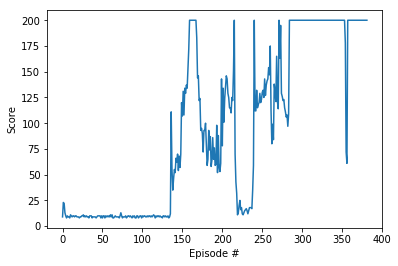

Actor(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=2, bias=True)
    (5): Softmax()
  )
)
Max Score 200.000000 at 159
Percentile [25,50,75] : [ 10.  82. 200.]
Variance : 6435.419


In [17]:
start_time = time.time()
scores = ddpg(n_episodes=1000) # 2000,1500 ; quick test 100,500
env.close() # Close the environment
print('Elapsed : {}'.format(timedelta(seconds=time.time() - start_time)))
print(datetime.now())
#
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
print(agent.actor_local)
# print(agent.critic_local)
print('Max Score {:.2f} at {}'.format(np.max(scores), np.argmax(scores)))
print('Percentile [25,50,75] : {}'.format(np.percentile(scores,[25,50,75])))
print('Variance : {:.3f}'.format(np.var(scores)))

### 2.3. Run logs & Notes

1. A place to keep the statistics and qualitative observations
2. It is easier to keep notes as soon as a run is done
3. Also a place to keep future explorations

### Logs
#### 1/13/19

1. Tried Softmax for actor, tried Sigmoid (with action_size=1) - was tanh()
    * LR : Actor = 0.01, Critic = 0.001
    * network 8 X 8
1. Doesn't go beyond 10-11 steps when episode = 1500, buffer = 512
2. No clue when it will wake up - episode = 15000; no dice so far
3. Buffer = 2048 no change
4. Took out batchnorm
5. Back to softmax
6. Took out clip(-1,1)
    * No change score ~10
7. tau = 0.05 - started learning - Am seeing the scores in the 20s! See if it passes nope stays at 20s
8. network 400 X 300 ! goes back to a score of 10
1. Network 36 X 8 ! Nope no good
1. Network 4 X 4 - very small !
1. Buffer = 4096, Batch = 32 meanders around a score of 10 for 10000 episodes !
1. softmax(-1) definite progress - goes upto 200, but then gets 10 as well ! After 1100, it is steady !
 * Solved in 1029 episodes !
 * Was about to throw the towel ! Took me a day ! Was going to go back to A2C !
 * From 1300 onwards it gets prfect 200
 * __added noise and that saved the day !__
1. back to 16 X 8 Network, batch = 64, 1500 episodes (was 15,000 ! and didn't do any good. The progress of a learning network is evident)
 * would have solved under 300, but a few black sheep epidodes bring the average down ;o(
 * 860 episodes. Between 300 and 800, it went down and came back !
1. Cleaned up a little bit and ran again - 282 Episodes !

### 2.4. Test Area

In [ ]:
env.close()

## Part 3 : Run a stored Model or the learned model

### Note
Here we are saving and loading the whole model. We cal also save & load the state dict

https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [21]:
# Load parameters from the saved file
# The file has the parameters of the model that has the highest score during training
# agent = torch.load('checkpoint.pth')

In [20]:
start_time = time.time()
scores=[]
for i in range(10): # 10 episodes
    state = env.reset()                                # reset the environment & get the current state
    score = 0                                          # initialize the score
    steps = 0                                          # Keep track of the number of steps
    while True:
        action = agent.act(state)                      # select an action, treat as softmax probabilities
        act = int(np.random.choice(action_size, p=action)) # for Softmax
        next_state, reward, done, _ = env.step(act)    # send the action to the environment
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            break
        else:
            steps += 1
    scores.append(score)
    print("Episode : {:2d} Score : {:5.2f} Steps : {}".format(i+1,score,steps))
# Print stats at the end the run
print('Mean of {} episodes = {}'.format(i+1,np.mean(scores)))
print('Elapsed : {}'.format(timedelta(seconds=time.time() - start_time)))
print(datetime.now())
env.close()

Episode :  1 Score : 200.00 Steps : 199
Episode :  2 Score : 200.00 Steps : 199
Episode :  3 Score : 200.00 Steps : 199
Episode :  4 Score : 200.00 Steps : 199
Episode :  5 Score : 200.00 Steps : 199
Episode :  6 Score : 200.00 Steps : 199
Episode :  7 Score : 200.00 Steps : 199
Episode :  8 Score : 200.00 Steps : 199
Episode :  9 Score : 200.00 Steps : 199
Episode : 10 Score : 200.00 Steps : 199
Mean of 10 episodes = 200.0
Elapsed : 0:00:00.517737
2019-01-13 18:18:07.700678
